In [5]:
# Minimal pipeline cell
# pip install facenet-pytorch retina-face opencv-python matplotlib numpy pandas pillow pillow-heif torch torchvision tf-keras tqdm

from pathlib import Path
import random
import shutil
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageOps

# heic support
import pillow_heif
pillow_heif.register_heif_opener()

from augmentation import AugmentConfig, augment_training_folder
from face_embedder import FaceNetRetinaEmbedder


IMG_EXTS = {".jpg", ".jpeg", ".png", ".heic", ".heif"}

DATASET_DIR = Path("dataset")
SPLITS_DIR = Path("splits")
EMB_DIR = Path("emb_csv")
SPECIAL_ONLINE_FOLDER = "Ani"
STRANGERS_FOLDER = "Strangers"

SEED = 33
random.seed(SEED)

In [6]:
# -------------------------
# 1) Delete mp4
# -------------------------
for p in DATASET_DIR.rglob("*.mp4"):
    p.unlink()

# -------------------------
# 2) Split into train/val/test + online
#    Convert everything to JPG while copying
# -------------------------
# (clear old splits if you want)
SPLITS_DIR.mkdir(exist_ok=True)

for split_name in ["train", "val", "test", "online", "strangers"]:
    (SPLITS_DIR / split_name).mkdir(parents=True, exist_ok=True)

for person_dir in sorted([p for p in DATASET_DIR.iterdir() if p.is_dir()]):
    person = person_dir.name
    img_paths = sorted([p for p in person_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])
    if not img_paths:
        continue

    # Special folders
    if person == SPECIAL_ONLINE_FOLDER:
        splits = {"online": img_paths}

    elif person == STRANGERS_FOLDER:
        splits = {"strangers": img_paths}

    else:
        random.shuffle(img_paths)
        n = len(img_paths)
        n_train = int(0.6 * n)
        n_val = int(0.2 * n)
        splits = {
            "train": img_paths[:n_train],
            "val": img_paths[n_train:n_train + n_val],
            "test": img_paths[n_train + n_val:],
        }


    for split_name, files in splits.items():
        out_person_dir = SPLITS_DIR / split_name / person
        out_person_dir.mkdir(parents=True, exist_ok=True)

        for src in files:
            # load with EXIF transpose (fixes phone rotations), convert to RGB, save JPG
            img = Image.open(src)
            img = ImageOps.exif_transpose(img).convert("RGB")

            out_path = out_person_dir / (src.stem + ".jpg")
            # avoid overwrites if duplicate names exist
            k = 1
            while out_path.exists():
                out_path = out_person_dir / f"{src.stem}_{k}.jpg"
                k += 1

            img.save(out_path, format="JPEG", quality=95, optimize=True)

print("Split done.")
print("Counts:")
for split_name in ["train", "val", "test", "online", "strangers"]:
    split_dir = SPLITS_DIR / split_name
    count = sum(1 for p in split_dir.rglob("*.jpg"))
    print(f"  {split_name}: {count}")



Split done.
Counts:
  train: 548
  val: 180
  test: 191
  online: 43
  strangers: 49


In [7]:
# -------------------------
# 3) Augment TRAIN only
# -------------------------
cfg = AugmentConfig(
    flip_prob=0.70,
    brightness_prob=0.15,
    contrast_prob=0.10,
    grayscale_prob=0.05,
    brightness_range=(0.75, 1.25),
    contrast_range=(0.75, 1.25),
)
augment_training_folder(SPLITS_DIR / "train", cfg=cfg, seed=SEED, verbose=True)



{'flipped': 385, 'bright': 69, 'contrast': 48, 'gray': 35, 'skipped': 0}


{'flipped': 385, 'bright': 69, 'contrast': 48, 'gray': 35, 'skipped': 0}

Embedding train:   0%|          | 0/1085 [00:00<?, ?it/s]

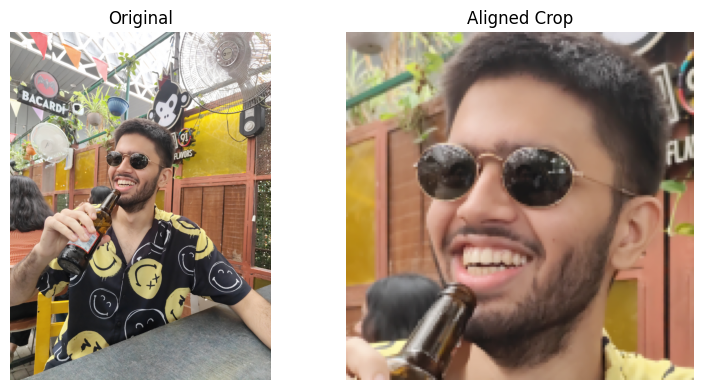

Embedding train:  26%|██▌       | 280/1085 [02:07<04:39,  2.88it/s]

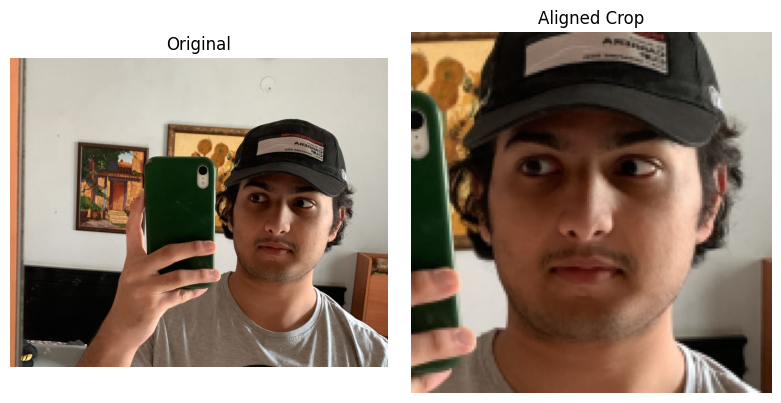

Embedding train:  52%|█████▏    | 560/1085 [04:52<03:32,  2.47it/s]

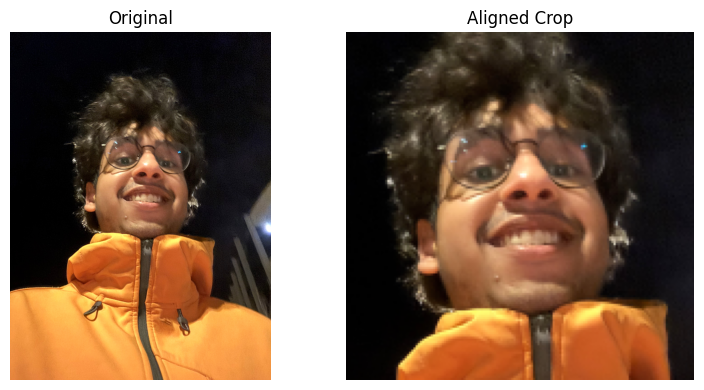

Embedding train:  77%|███████▋  | 840/1085 [07:03<03:08,  1.30it/s]

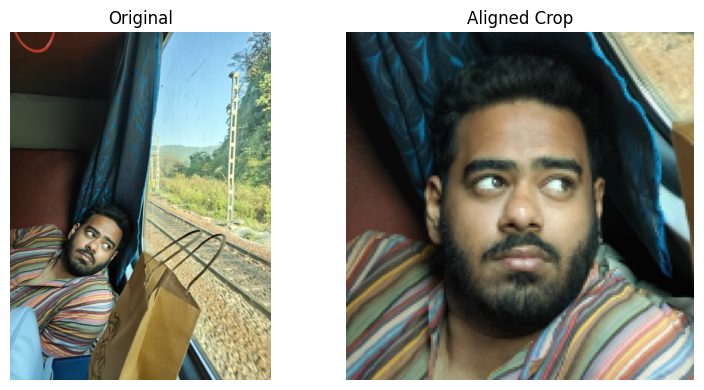

Embedding train: 100%|██████████| 1085/1085 [09:03<00:00,  2.00it/s]


train: saved 1074 embeddings to emb_csv/train_embeddings.csv | failed=11


Embedding val: 100%|██████████| 180/180 [01:34<00:00,  1.91it/s]


val: saved 177 embeddings to emb_csv/val_embeddings.csv | failed=3


Embedding test: 100%|██████████| 191/191 [01:35<00:00,  2.01it/s]


test: saved 189 embeddings to emb_csv/test_embeddings.csv | failed=2


Embedding online: 100%|██████████| 43/43 [00:18<00:00,  2.37it/s]


online: saved 42 embeddings to emb_csv/online_embeddings.csv | failed=1


Embedding strangers: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]

strangers: saved 47 embeddings to emb_csv/strangers_embeddings.csv | failed=2


In [10]:
# -------------------------
# 4) Embeddings -> CSV for train/val/test/online
# -------------------------
EMB_DIR.mkdir(exist_ok=True)
embedder = FaceNetRetinaEmbedder(device="cuda", pretrained="vggface2")

def write_csv_for_split(split_name: str, show_every: int = 0):
    split_dir = SPLITS_DIR / split_name
    rows = []
    failed = []

    all_imgs = sorted([p for p in split_dir.rglob("*.jpg")])
    for i, img_path in enumerate(tqdm(all_imgs, desc=f"Embedding {split_name}")):
        person = img_path.parent.name  # folder name = identity
        show_debug = (show_every > 0 and i % show_every == 0)

        emb = embedder.embed(str(img_path), show_debug=show_debug)
        if emb is None:
            failed.append(str(img_path))
            continue

        vec = emb.detach().float().cpu().numpy()
        row = {"folder_name": person, "file_name": img_path.name}
        for j in range(vec.shape[0]):
            row[f"e{j}"] = float(vec[j])
        rows.append(row)

    df = pd.DataFrame(rows)
    out_csv = EMB_DIR / f"{split_name}_embeddings.csv"
    df.to_csv(out_csv, index=False)

    if failed:
        (EMB_DIR / f"{split_name}_failed.txt").write_text("\n".join(failed))
    print(f"{split_name}: saved {len(rows)} embeddings to {out_csv} | failed={len(failed)}")

# show debug occasionally only for train (change if you want)
write_csv_for_split("train", show_every=280)
write_csv_for_split("val", show_every=0)
write_csv_for_split("test", show_every=0)
write_csv_for_split("online", show_every=0)
write_csv_for_split("strangers", show_every=0)
